In [18]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from collections import Counter
import matplotlib.pyplot as plt
import graphviz
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df=pd.read_csv('drug200.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [3]:
df.shape

(200, 6)

In [4]:
df[df.duplicated()]

,Age,Sex,BP,Cholesterol,Na_to_K,Drug


In [5]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [6]:
x=df.drop('Drug',axis=1)
y=df['Drug']

In [7]:
# Entropy calculation
def entropy(labels):
    probs = [v / len(labels) for v in Counter(labels).values()]
    return -sum(p * np.log2(p) for p in probs)


In [8]:
# Information gain
def info_gain(df, feature, target='Drug'):
    total_entropy = entropy(df[target])
    values = df[feature].unique()
    weighted_entropy = 0
    for v in values:
        subset = df[df[feature] == v]
        weighted_entropy += (len(subset) / len(df)) * entropy(subset[target])
    return total_entropy - weighted_entropy


In [9]:
# Split function (based on threshold)
def split(df, feature, threshold):
    left = df[df[feature] <= threshold]
    right = df[df[feature] > threshold]
    return left, right

In [10]:
# Best split function (entropy-based)
def best_split(df, target='Drug'):
    best_feature = None
    best_threshold = None
    best_gain = -1
    for feature in df.columns[:-1]:
        thresholds = df[feature].unique()
        for t in thresholds:
            left, right = split(df, feature, t)
            if len(left) == 0 or len(right) == 0:
                continue
            left_entropy = entropy(left[target])
            right_entropy = entropy(right[target])
            p = len(left) / len(df)
            gain = entropy(df[target]) - (p * left_entropy + (1 - p) * right_entropy)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = t
    return best_feature, best_threshold


In [11]:
# Build tree (recursive)
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, label=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.label = label

def build_tree(df, target='Drug'):
    if len(set(df[target])) == 1:
        return Node(label=df[target].iloc[0])

    feature, threshold = best_split(df, target)
    if feature is None:
        return Node(label=Counter(df[target]).most_common(1)[0][0])

    left_data, right_data = split(df, feature, threshold)
    left = build_tree(left_data, target)
    right = build_tree(right_data, target)
    return Node(feature=feature, threshold=threshold, left=left, right=right)

In [12]:
# Prediction
def predict(tree, row):
    if tree.label is not None:
        return tree.label
    if row[tree.feature] <= tree.threshold:
        return predict(tree.left, row)
    else:
        return predict(tree.right, row)

In [13]:
# Gini Index
def gini_index(labels):
    probs = [v / len(labels) for v in Counter(labels).values()]
    return 1 - sum(p ** 2 for p in probs)

# Best split using Gini
def best_split_gini(df, target='Drug'):
    best_feature = None
    best_threshold = None
    best_gini = 1
    for feature in df.columns[:-1]:
        thresholds = df[feature].unique()
        for t in thresholds:
            left, right = split(df, feature, t)
            if len(left) == 0 or len(right) == 0:
                continue
            p = len(left) / len(df)
            gini = p * gini_index(left[target]) + (1 - p) * gini_index(right[target])
            if gini < best_gini:
                best_gini = gini
                best_feature = feature
                best_threshold = t
    return best_feature, best_threshold

# Build Gini Tree
def build_tree_gini(df, target='Drug'):
    if len(set(df[target])) == 1:
        return Node(label=df[target].iloc[0])

    feature, threshold = best_split_gini(df, target)
    if feature is None:
        return Node(label=Counter(df[target]).most_common(1)[0][0])

    left_data, right_data = split(df, feature, threshold)
    left = build_tree_gini(left_data, target)
    right = build_tree_gini(right_data, target)
    return Node(feature=feature, threshold=threshold, left=left, right=right)


In [14]:
#visualize the tree
def visualize_tree(node, dot=None, node_id=0):
    if dot is None:
        dot = graphviz.Digraph()

    curr_id = str(node_id)
    if node.label is not None:
        dot.node(curr_id, f"Label: {node.label}")
    else:
        if isinstance(node.threshold, (int, float)):
            dot.node(curr_id, f"{node.feature} <= {node.threshold:.2f}")
        else:
            dot.node(curr_id, f"{node.feature} <= {node.threshold}")

        left_id = str(node_id * 2 + 1)
        right_id = str(node_id * 2 + 2)

        dot.edge(curr_id, left_id, label="True")
        dot.edge(curr_id, right_id, label="False")

        visualize_tree(node.left, dot, node_id * 2 + 1)
        visualize_tree(node.right, dot, node_id * 2 + 2)

    return dot

Accuracy (Entropy): 1.0
Accuracy (Gini): 1.0


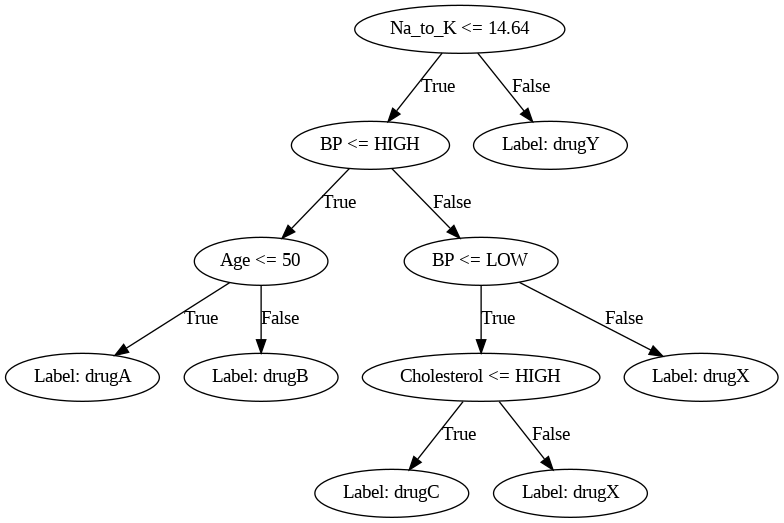

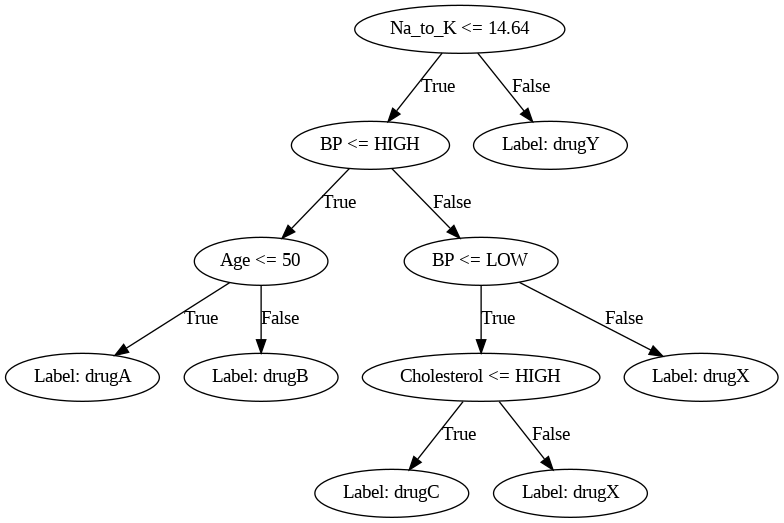

In [15]:
from sklearn.metrics import accuracy_score

# Train/test split
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Entropy Tree
tree_entropy = build_tree(train_data)
preds_entropy = [predict(tree_entropy, row) for _, row in test_data.iterrows()]
acc_entropy = accuracy_score(test_data['Drug'], preds_entropy)

# Gini Tree
tree_gini = build_tree_gini(train_data)
preds_gini = [predict(tree_gini, row) for _, row in test_data.iterrows()]
acc_gini = accuracy_score(test_data['Drug'], preds_gini)

print("Accuracy (Entropy):", acc_entropy)
print("Accuracy (Gini):", acc_gini)

# Visualize
from IPython.display import Image

# Display Entropy Tree
dot_entropy = visualize_tree(tree_entropy)
dot_entropy.render("tree_entropy", format="png", cleanup=True)
display(Image(filename="tree_entropy.png"))

# Display Gini Tree
dot_gini = visualize_tree(tree_gini)
dot_gini.render("tree_gini", format="png", cleanup=True)
display(Image(filename="tree_gini.png"))


In [19]:
print("=== Entropy Tree Metrics ===")
print("Confusion Matrix:\n", confusion_matrix(test_data['Drug'], preds_entropy))
print("Classification Report:\n", classification_report(test_data['Drug'], preds_entropy))
print("=== Gini Tree Metrics ===")
print("Confusion Matrix:\n", confusion_matrix(test_data['Drug'], preds_gini))
print("Classification Report:\n", classification_report(test_data['Drug'], preds_gini))

=== Entropy Tree Metrics ===
Confusion Matrix:
 [[ 6  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 11  0]
 [ 0  0  0  0 15]]
Classification Report:
               precision    recall  f1-score   support

       drugA       1.00      1.00      1.00         6
       drugB       1.00      1.00      1.00         3
       drugC       1.00      1.00      1.00         5
       drugX       1.00      1.00      1.00        11
       drugY       1.00      1.00      1.00        15

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

=== Gini Tree Metrics ===
Confusion Matrix:
 [[ 6  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 11  0]
 [ 0  0  0  0 15]]
Classification Report:
               precision    recall  f1-score   support

       drugA       1.00      1.00      1.00         6
       drugB       1.00      1.00      1.00         3
       drugC       1.00  